<a href="https://colab.research.google.com/github/yohanesnuwara/pyresim/blob/master/simulators/benchmarks/PyReSim_benchmark1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!git clone https://github.com/yohanesnuwara/pyresim

Cloning into 'pyresim'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 863 (delta 54), reused 0 (delta 0), pack-reused 769
Receiving objects: 100% (863/863), 312.12 KiB | 4.00 MiB/s, done.
Resolving deltas: 100% (500/500), done.


In [ ]:
import sys
sys.path.append('/content/pyresim/functions')

In [ ]:
from input_output import read_input, read_depth
from boundary import boundary_floweq1d
from gridding import source1d
from solver import lhs_coeffs1d_welltype, rhs_constant1d_welltype
from transmissibility import transmissibility1d, transmissibility1d_boundary
from wellblock import fraction_wellblock_geometric_factor
from wellsimulation import solution_well1d
from potential import potential_term1d

## Simulation

In [ ]:
def read_input(filepath):
  """
  Read input data (TXT file)

  Input:

  filepath = path to the input file (TXT format)

  Output:

  reservoir_input = reservoir data input (as Python dictionary format)
  contains:
  xi, yi, dx, dy, dz, kx, ky, kz, poro, rho, cpore, mu, B

  west_boundary, east_boundary, south_boundary, north_boundary = 
  reservoir boundary information (as Python dictionary format)
  contains: 
  * type (boundary type: 'constant_pressure', 'constant_pressuregrad', 'constant_rate', 'no_flow')
  * loc (location of grid blocks: either 'all' means all gridblocks have the same boundary, OR the specified coordinates)
  * value (boundary value: 'constant_pressure' in psi, 'constant_pressuregrad' in psi/ft, 'constant_rate' in STB/D)

  well = well information (as Python dictionary format)  
  contains:
  * name (well name)
  * rw (well radius in inch)
  * loc = (well coordinate)
  * skin (well skin)
  * well_config (well configuration for wells in the RESERVOIR BOUNDARY: 0, 1, 2, and 3. See DOCS for details)  
  * condition (well operating conditions: 'constant_fbhp', 'constant_pressuregrad', 'constant_rate', 'shutin')
  * value (value of the operating conditions: 'constant_fbhp' in psi, 'constant_pressuregrad' in psi/ft, 'constant_rate' in STB/D)

  """
  import numpy as np

  # reservoir input
  prop = np.loadtxt(filepath, max_rows=1, skiprows=12)
  xi, yi, zi = (prop[0]).astype(int), (prop[1]).astype(int), (prop[2]).astype(int)
  dx, dy, dz = prop[3], prop[4], prop[5]
  kx, ky, kz, poro, rho = prop[6], prop[7], prop[8], prop[9], prop[10]
  cpore, mu, B, cfluid = prop[11], prop[12], prop[13], prop[14]

  if yi==0 and zi==0:
    # reservoir is 1D

    ## create reservoir input dictionary
    reservoir_input = {'xi': xi, 'dx': dx, 'dy': dy, 'dz': dz, 'kx': kx, 
                       'poro': poro, 'rho': rho, 'cpore': cpore, 
                       'mu': mu, 'B': B, 'cfluid': cfluid}

    # well input
    skiprow_wells = np.array([22,25,28,31,37,40])
    wells = []
    for i in range(len(skiprow_wells)):
      well = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_wells[i], delimiter=',')
      wells.append(well)

    well_xsc, well_rw, well_skin, well_value, well_config = wells[0], wells[2], wells[3], wells[4], wells[5]
    
    well_name = np.loadtxt(filepath, max_rows=1, skiprows=19, delimiter=',', dtype=np.str) 
    well_condition = np.loadtxt(filepath, max_rows=1, skiprows=34, delimiter=',', dtype=np.str)

    well_loc = well_xsc.tolist()
    well_name = np.array(well_name)

    ## create well information dictionary
    well = {'well_name': well_name,
            'well_loc': well_loc,
            'well_rw': well_rw,
            'well_skin': well_skin,
            'well_condition': well_condition,
            'well_value': well_value,
            'well_config': well_config}

    # reservoir boundary
    skiprow_type = np.array([54, 67])
    skiprow_value = np.array([57, 70])

    btype = []; bvalue = []
    for i in range(len(skiprow_type)):
      type = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_type[i], dtype=np.str)
      value = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_value[i])
      # loc = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_loc[i], dtype=np.str)
      btype.append(type); bvalue.append(value)

    west_type, east_type = btype[0], btype[1]
    west_value, east_value = bvalue[0], bvalue[1]

    ## create reservoir boundary information

    east_boundary = {"type": east_type,
                      "value": east_value}

    west_boundary = {"type": west_type,
                      "value": west_value} 

    return reservoir_input, well, west_boundary, east_boundary 

  if yi!=0 and zi==0:
    # reservoir is 2D

    ## create reservoir input dictionary
    reservoir_input = {'xi': xi, 'yi': yi, 'dx': dx, 'dy': dy, 'dz': dz, 'kx': kx, 
                        'ky': ky, 'poro': poro, 'rho': rho, 'cpore': cpore, 
                        'mu': mu, 'B': B, 'cfluid': cfluid}

    # well input
    skiprow_wells = np.array([22,25,28,31,37,40])
    wells = []
    for i in range(len(skiprow_wells)):
      well = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_wells[i], delimiter=',')
      wells.append(well)

    well_xsc, well_ysc, well_rw, well_skin, well_value, well_config = wells[0], wells[1], wells[2], wells[3], wells[4], wells[5]
    well_name = np.loadtxt(filepath, max_rows=1, skiprows=19, delimiter=',', dtype=np.str) 
    well_condition = np.loadtxt(filepath, max_rows=1, skiprows=34, delimiter=',', dtype=np.str)

    ## merge the xsc and ysc well coordinates into one coordinate
    well_loc = np.zeros((len(well_xsc),2))
    for i in range(len(well_xsc)):
      well_loc[i] = [well_xsc[i], well_ysc[i]]

    well_loc = well_loc.astype(int)
    well_loc = well_loc.tolist()

    ## create well information dictionary
    well = {'well_name': well_name,
            'well_loc': well_loc,
            'well_rw': well_rw,
            'well_skin': np.array([well_skin]),
            'well_condition': well_condition,
            'well_value': well_value,
            'well_config': well_config}

    # reservoir boundary
    skiprow_type = np.array([54, 67, 80, 93])
    skiprow_value = np.array([57, 70, 83, 96])
    skiprow_loc = np.array([51, 64, 77, 90])

    btype = []; bvalue = []; bloc = []
    for i in range(len(skiprow_type)):
      type = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_type[i], dtype=np.str)
      value = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_value[i])
      loc = np.loadtxt(filepath, max_rows=1, skiprows=skiprow_loc[i], dtype=np.str)      
      btype.append(type); bvalue.append(value); bloc.append(loc)

    west_type, east_type, south_type, north_type = btype[0], btype[1], btype[2], btype[3]
    west_value, east_value, south_value, north_value = bvalue[0], bvalue[1], bvalue[2], bvalue[3]
    west_loc, east_loc, south_loc, north_loc = bloc[0], bloc[1], bloc[2], bloc[3]

    ## create reservoir boundary information

    east_boundary = {"type": east_type,
                      "value": east_value,
                      "loc": east_loc}

    west_boundary = {"type": west_type,
                      "value": west_value,
                      "loc": west_loc}

    north_boundary = {"type": north_type,
                      "value": north_value,
                      "loc": north_loc}

    south_boundary = {"type": south_type,
                      "value": south_value,
                      "loc": south_loc}   

    return reservoir_input, well, west_boundary, east_boundary, south_boundary, north_boundary 

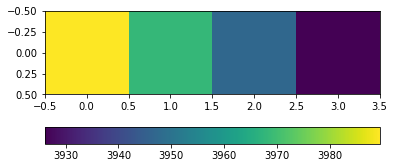

In [ ]:
import warnings
warnings.filterwarnings("ignore")

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/benchmarks/benchmark1d.txt'

# call the read_input function to read input data
reservoir_input, wells, west, east = read_input(filepath)

"""""""""""
ADD ELEVATION

N.b.: there are 2 approaches to add elevation in case of ELEVATED grid block
      * upload the depth input file using function 'read_depth'
      * create synthetic depth data using Numpy method in Python
"""""""""""

## Read or create synthetic depth data
depthpath = '/content/pyresim/input/basic/basic1d_depth.txt'
x, depth = read_depth(depthpath)

## Boundary depth (if not elevated, leave both with ZEROS)
## then add to the 'west_boundary' and 'east_boundary' already created before
west_depth, east_depth = 0, 0
west['depth'] = west_depth 
east['depth'] = east_depth

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
B = reservoir_input['B']
mu = reservoir_input['mu']
rho = reservoir_input['rho']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_rw']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

# calculate elevation
elev = [j - i for i, j in zip(depth[:-1], depth[1:])]

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
well_loc = np.array(well_loc).astype(int)
qsc = source1d(well_value, well_loc, xi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, kx, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create dataframe from the created dictionary
well_df = pd.DataFrame.from_dict(wells)

well_mu = np.full(len(well_loc), mu)
well_B = np.full(len(well_loc), B)
well_dz = np.full(len(well_loc), dz)

well_df['well_loc'] = well_loc
well_df['well_dz'] = dz
well_df['well_kh'] = kh
well_df['well_mu'] = mu
well_df['well_B'] = B
well_df['well_Gw'] = Gw

"""""""""""
SIMULATION
"""""""""""

T_min_array, T_plus_array = np.zeros(xi), np.zeros(xi)
lhs_mat = np.array([[0.] * xi] * xi)
rhs_mat = np.array([[0.] * 1] * xi)

for i in range(xi):

    T_min, T_plus = transmissibility1d(dx, dy, dz, kx, mu, B)

    if i == 0:
        # left boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(west['type'], dx, dy, dz, kx, mu, B, value=west['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = T_plus
        T_min = transmissibility1d_boundary(west['type'], dx, dy, dz, kx, mu, B)

        p_plus, p_min, p = lhs_coeffs1d_welltype('west', (i + 1), well_df, qsc, T_plus, T_min)

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, west['depth'], depth[i], depth[i + 1])

        ## RHS constants
        # rhs = rhs_constant('incompressible', west['type'], qsc[i], T_pb=T_min, p_b=west['value'])
        rhs = rhs_constant1d_welltype('incompressible', west['type'], (i + 1), well_df, potential_term, qsc_b, T_pb=T_min,
                                    p_b=west['value'])

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

        ## fill in RHS matrix (rhs_mat)   
        rhs_mat[i, 0] = rhs

    elif i == xi - 1:
        # right boundary

        ## flow rate from boundary
        qsc_b = boundary_floweq1d(east['type'], dx, dy, dz, kx, mu, B, value=east['value'], no_block=(i + 1))

        ## LHS coeffs
        T_plus = transmissibility1d_boundary(east['type'], dx, dy, dz, kx, mu, B)
        T_min = T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype('east', (i + 1), well_df, qsc, T_plus, T_min)

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, depth[i - 1], depth[i], east['depth'])

        ## RHS constants      
        # rhs = rhs_constant('incompressible', east['type'], qsc[i])    
        rhs = rhs_constant1d_welltype('incompressible', east['type'], (i + 1), well_df, potential_term, qsc_b,
                                    T_pb=T_plus, p_b=east['value'])

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs

    else:

        ## calculate potential term for the RHS constant

        T_plus, T_min = T_plus, T_min
        p_plus, p_min, p = lhs_coeffs1d_welltype(None, (i+1), well_df, qsc, T_plus, T_min) 
        # p_plus, p_min, p = lhs_coeffs1d(None, T_plus, T_min)

        ## calculate potential term for the RHS constant
        potential_term = potential_term1d(rho, T_min, T_plus, depth[i - 1], depth[i], depth[i + 1])

        ## RHS constants      
        rhs = -qsc[i] + potential_term

        ## fill in LHS matrix (lhs_mat)
        lhs_mat[i, i - 1] = p_min
        lhs_mat[i, i] = p
        lhs_mat[i, i + 1] = p_plus

        ## fill in RHS matrix (rhs_mat)    
        rhs_mat[i, 0] = rhs

        # print the transmissibility
    T_min_array[i], T_plus_array[i] = T_min, T_plus    

"""""""""""
PRESSURE SOLVER
"""""""""""

p_sol = np.linalg.solve(lhs_mat, rhs_mat)

"""""""""""
DISPLAY PRESSURE
"""""""""""

p_sol = p_sol.T.reshape(-1)
p_sol_ = np.expand_dims(p_sol, axis=0)  # or axis=1
plt.imshow(p_sol_)
plt.colorbar(orientation='horizontal')
plt.show() 

In [ ]:
p_sol

array([3989.4367685 , 3968.31030549, 3947.18384248, 3926.05737947])

In [ ]:
"""""""""""
WELL SIMULATION
"""""""""""

well_report = solution_well1d(well_df, p_sol)
well_report = well_report.drop(['well_dz', 'well_kh', 'well_mu', 'well_B', 'well_Gw'], 1)
well_report

,well_name,well_loc,well_rw,well_skin,well_condition,well_value,well_config,fbhp_sol,rate_sol
0,A,4,3.5,1.5,constant_rate,-600.0,0.0,3898.992647,-600.0
1,B,2,2.0,0.0,no_flow,0.0,0.0,3898.992647,-600.0
